<a href="https://colab.research.google.com/github/najouaelfethi/water_harvesting_project/blob/main/Water_Harvesting_Project_hourly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%config InlineBackend.figure_format = 'retina'

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from prophet import Prophet
import warnings
import logging
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import tensorflow as tf
import random
from tensorflow.keras.optimizers import AdamW



## Load the dataset

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/hourly_data.csv", sep=',', skiprows=range(0, 17))
df = dataset.copy()
df.head()

,YEAR,MO,DY,HR,T2M,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WD10M
0,2020,1,1,0,8.48,4.63,6.55,5.49,77.53,0.0,97.70,2.33,186.2
1,2020,1,1,1,8.14,3.69,5.92,5.15,74.43,0.0,97.69,2.65,190.7
2,2020,1,1,2,7.85,2.60,5.22,4.78,70.46,0.0,97.67,2.95,194.3
3,2020,1,1,3,7.61,1.56,4.58,4.42,66.24,0.0,97.66,3.25,196.3
4,2020,1,1,4,7.45,0.60,4.02,4.10,62.14,0.0,97.68,3.48,196.0


# Exploratory Data Analysis (EDA)

## Summary of dataset variables

In [ ]:
summary = pd.DataFrame({
    "Variable": df.columns,
    "Variable Type": [str(df[col].dtype) for col in df.columns],
    "Number of Samples": [df[col].count() for col in df.columns],
    "Range": [
        f"{df[col].min():.2f} - {df[col].max():.2f}"
        if pd.api.types.is_numeric_dtype(df[col]) else "N/A"
        for col in df.columns
    ],
    "Mean": [
        round(df[col].mean(), 2) if pd.api.types.is_numeric_dtype(df[col]) else "N/A"
        for col in df.columns
    ]
})

summary

,Variable,Variable Type,Number of Samples,Range,Mean
0,YEAR,int64,50400,2020.00 - 2025.00,2022.39
1,MO,int64,50400,1.00 - 12.00,6.33
2,DY,int64,50400,1.00 - 31.00,15.73
3,HR,int64,50400,0.00 - 23.00,11.50
4,T2M,float64,50400,2.47 - 47.51,20.82
5,T2MDEW,float64,50400,-11.90 - 23.13,8.59
6,T2MWET,float64,50400,-2.04 - 29.35,14.71
7,QV2M,float64,50400,1.49 - 18.55,7.61
8,RH2M,float64,50400,4.12 - 100.00,52.68
9,PRECTOTCORR,float64,50400,0.00 - 381.83,0.65


## Create datetime column

In [ ]:
#creating datetime column to fusionne les colonnes YEAR, MO, DY, HR cz python doesn't know the time continuity(won't understand it's a date) + time series models also regression needs continue time
df['datetime'] = pd.to_datetime(dict(year=df['YEAR'], month=df['MO'], day=df['DY'], hour=df['HR']))
df.head()

,YEAR,MO,DY,HR,T2M,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WD10M,datetime
0,2020,1,1,0,8.48,4.63,6.55,5.49,77.53,0.0,97.70,2.33,186.2,2020-01-01 00:00:00
1,2020,1,1,1,8.14,3.69,5.92,5.15,74.43,0.0,97.69,2.65,190.7,2020-01-01 01:00:00
2,2020,1,1,2,7.85,2.60,5.22,4.78,70.46,0.0,97.67,2.95,194.3,2020-01-01 02:00:00
3,2020,1,1,3,7.61,1.56,4.58,4.42,66.24,0.0,97.66,3.25,196.3,2020-01-01 03:00:00
4,2020,1,1,4,7.45,0.60,4.02,4.10,62.14,0.0,97.68,3.48,196.0,2020-01-01 04:00:00


## Sort, set index & resample

In [ ]:
#sorting datetime so time series will flows correctly from oldest to newest
df = df.sort_values('datetime').reset_index(drop=True)

#Making datetime the time axis of the dataset so this transforms the DataFrame into a true time series object
df = df.set_index('datetime')
df.head()

,YEAR,MO,DY,HR,T2M,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WD10M
datetime,,,,,,,,,,,,,
2020-01-01 00:00:00,2020,1,1,0,8.48,4.63,6.55,5.49,77.53,0.0,97.70,2.33,186.2
2020-01-01 01:00:00,2020,1,1,1,8.14,3.69,5.92,5.15,74.43,0.0,97.69,2.65,190.7
2020-01-01 02:00:00,2020,1,1,2,7.85,2.60,5.22,4.78,70.46,0.0,97.67,2.95,194.3
2020-01-01 03:00:00,2020,1,1,3,7.61,1.56,4.58,4.42,66.24,0.0,97.66,3.25,196.3
2020-01-01 04:00:00,2020,1,1,4,7.45,0.60,4.02,4.10,62.14,0.0,97.68,3.48,196.0


## Reindexing datetime

In [ ]:
#recreates a continuous hourly timeline from the first to the last timestamp in the dataset even if some hours were missing in the original data
#for example a sensor failed at h=2AM (we will have h=1AM then h=3AM) so here h=2 is missing so after reindexing it will be filled with NaaN
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
df = df.reindex(full_index)
df.head()

,YEAR,MO,DY,HR,T2M,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WD10M
2020-01-01 00:00:00,2020,1,1,0,8.48,4.63,6.55,5.49,77.53,0.0,97.70,2.33,186.2
2020-01-01 01:00:00,2020,1,1,1,8.14,3.69,5.92,5.15,74.43,0.0,97.69,2.65,190.7
2020-01-01 02:00:00,2020,1,1,2,7.85,2.60,5.22,4.78,70.46,0.0,97.67,2.95,194.3
2020-01-01 03:00:00,2020,1,1,3,7.61,1.56,4.58,4.42,66.24,0.0,97.66,3.25,196.3
2020-01-01 04:00:00,2020,1,1,4,7.45,0.60,4.02,4.10,62.14,0.0,97.68,3.48,196.0


## Verify missing values

In [ ]:
missing_percent = df.isna().mean() * 100
print("Percentage of missing values:")
print(missing_percent)

Percentage of missing values:
YEAR           0.0
MO             0.0
DY             0.0
HR             0.0
T2M            0.0
T2MDEW         0.0
T2MWET         0.0
QV2M           0.0
RH2M           0.0
PRECTOTCORR    0.0
PS             0.0
WS10M          0.0
WD10M          0.0
dtype: float64


## Statistics

In [ ]:
summary = df.describe()
print("\n Statistical summary:")
print(summary)


 Statistical summary:
               YEAR            MO            DY            HR           T2M  \
count  50400.000000  50400.000000  50400.000000  50400.000000  50400.000000   
mean    2022.390000      6.325714     15.728095     11.500000     20.818241   
std        1.661282      3.386787      8.799106      6.922255      8.415295   
min     2020.000000      1.000000      1.000000      0.000000      2.470000   
25%     2021.000000      3.000000      8.000000      5.750000     14.250000   
50%     2022.000000      6.000000     16.000000     11.500000     19.840000   
75%     2024.000000      9.000000     23.000000     17.250000     26.270000   
max     2025.000000     12.000000     31.000000     23.000000     47.510000   

             T2MDEW        T2MWET          QV2M          RH2M   PRECTOTCORR  \
count  50400.000000  50400.000000  50400.000000  50400.000000  50400.000000   
mean       8.592478     14.705352      7.606963     52.677698      0.651850   
std        5.054881      5.2

**Data Interpretation** <br>
-count: 50400 rows -> that’s about 5.75 years of hourly data (50400 ÷ 24 presque 2100 days ≈ 5.75 years), which fits perfectly with the range 2020–2025 <br>
-T2M: Warm region(possible desert or coastal climate) <br>
-T2MDEW: Reasonable -> dew point < air temp <br>
-T2MWET(temp humide): Logical range between T2M and T2MDEW <br>
=> dew point is always ≤ air temperature <br>
-RH: Very good, it covers full realistic humidity range <br>
-QV2M(qte vapeur d'eau totale disponible à condenser): Raisonnable range for near surface humidity <br>
=> Humidity and vapor are coherent low humidity (RH ~4%) happens in hot/dry hours and high humidity (RH -> 100%) likely at night/morning <br>
-PRECTOTCORR: max is 381 mm/hour is unrealistically high -> almost certainly a sensor or data error (outlier). Typical intense rainfall is 20–50 mm/hour max <br>
-WS10M: Normal range, Wind speeds up to 15 m/s (presque 54 km/h) <br>
-WD10M: Correct, Wind direction cycles correctly (0–360°) <br>
-PS: Normally, surface pressure presque 950–1050 hPa, so likely units are in kPa (1 kPa = 10 hPa) we need to multiply PS by 10 to get standard hPa later <br>





## Detect outliers (outside physical boundaries)

In [ ]:
bounds = {
    'T2M': (-20, 50),
    'T2MDEW': (-20, 50),
    'RH2M': (0, 100),
    'PS': (850, 1050) #en kPa
}

#Detect outliers (hors bornes physiques)
for col, (min_val, max_val) in bounds.items():
    if col in df.columns:
        outliers = df[(df[col] < min_val) | (df[col] > max_val)]
        print(f" {col}: {len(outliers)} valeurs hors bornes")

 T2M: 0 valeurs hors bornes
 T2MDEW: 0 valeurs hors bornes
 RH2M: 0 valeurs hors bornes
 PS: 50400 valeurs hors bornes


## Gap detection & report

In [ ]:
df['gap'] = (df.index.to_series().diff() > pd.Timedelta('1h')).astype(int)
nb_gaps = df['gap'].sum()
print(f"\n Nombre de gaps horaires détectés (>1h entre deux points) : {nb_gaps}")

print("\n Rapport QA résumé :")
print(f"- Données horaires de {df.index.min()} à {df.index.max()}")
print(f"- Nombre total d'heures attendues : {len(full_index)}")
print(f"- Pourcentage de données manquantes global : {df.isna().mean().mean()*100:.2f}%")


 Nombre de gaps horaires détectés (>1h entre deux points) : 0

 Rapport QA résumé :
- Données horaires de 2020-01-01 00:00:00 à 2025-09-30 23:00:00
- Nombre total d'heures attendues : 50400
- Pourcentage de données manquantes global : 0.00%


## Data distribution using kernel density estimation (KDE)


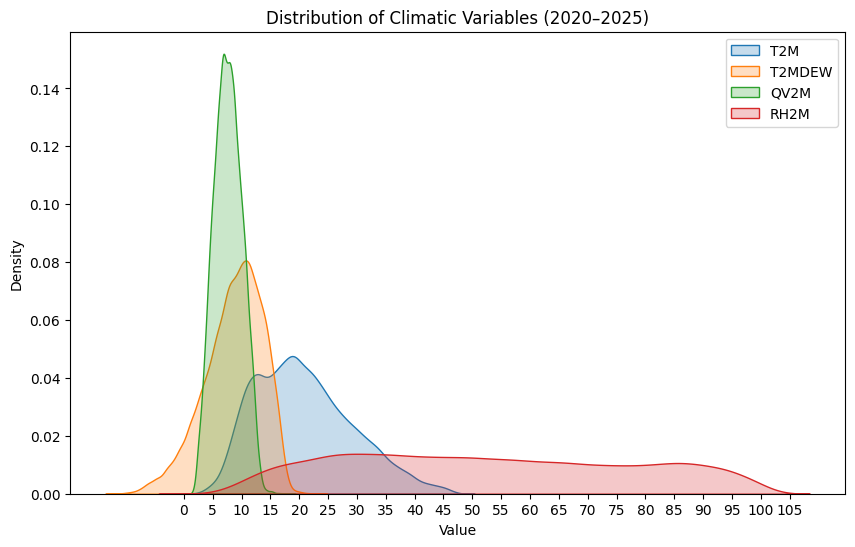

In [ ]:
#kernel density estimation (KDE) that shows the distribution of the main climatic variables
#density means that many data points have values close to that point(in that specific range)
variables = ["T2M", "T2MDEW", "QV2M", "RH2M"]
plt.figure(figsize=(10,6))
for var in variables:
    sns.kdeplot(df[var], label=var, fill=True)
plt.title("Distribution of Climatic Variables (2020–2025)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.xticks(np.arange(0, df[variables].max().max() + 10, 5))# start at 0, step by 5
plt.savefig("distribution_kde.png", dpi=300, bbox_inches='tight')
plt.show()

**Data Interpretation**<br>
-The air temperature (T2M) has one main peak and is slightly higher with most values between 10°C and 30°C.<br>
-The dew point temperature (T2MDEW) is mostly between 10°C and 20°C, showing that air moisture stays quite stable and follows the same trend as temperature.<br>
-The specific humidity (QV2M) has a clear and narrow peak around 5–10 g/kg, meaning the amount of water vapor in the air is generally constant through the seasons.<br>
-The relative humidity (RH2M) curve is much wider and flatter, going from 20% to more than 100%, showing that humidity levels change a lot depending on the time of day and season.

## Data Visualization

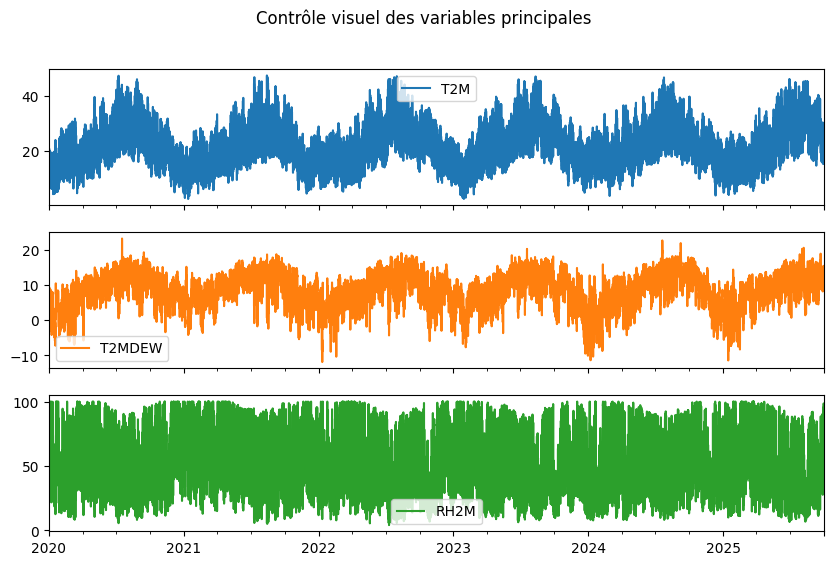

In [ ]:
df[['T2M', 'T2MDEW', 'RH2M']].plot(subplots=True, figsize=(10,6), title="Contrôle visuel des variables principales")
plt.savefig("data_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

**Data Interpretation** <br>
-Air temperature (T2M) follows a regular yearly cycle, with higher temperatures in summer and lower in winter. Short-term fluctuations also appear due to daily weather changes. <br>
-Dew point temperature (T2MDEW) follows the same seasonal pattern as air temperature but with lower values, which is expected since dew point depends on moisture content. It remains more stable than T2M. <br>
-Relative humidity (RH2M) is much more irregular. It varies strongly from hour to hour and does not follow a smooth seasonal curve. This is a normal behavior because humidity reacts quickly to short-term atmospheric conditions (rain, evaporation, wind, cloudiness).

# Data Cleaning and Preprocessing

## Fixing Unit of PS(pression)

In [ ]:
#PS from kPa to hPa
if df['PS'].mean() < 200:
    df['PS'] = df['PS'] * 10
df['PS'].head()

,PS
2020-01-01 00:00:00,977.0
2020-01-01 01:00:00,976.9
2020-01-01 02:00:00,976.7
2020-01-01 03:00:00,976.6
2020-01-01 04:00:00,976.8


# When and Why the Air Condenses: Feature Insights

## Correlation heatmap

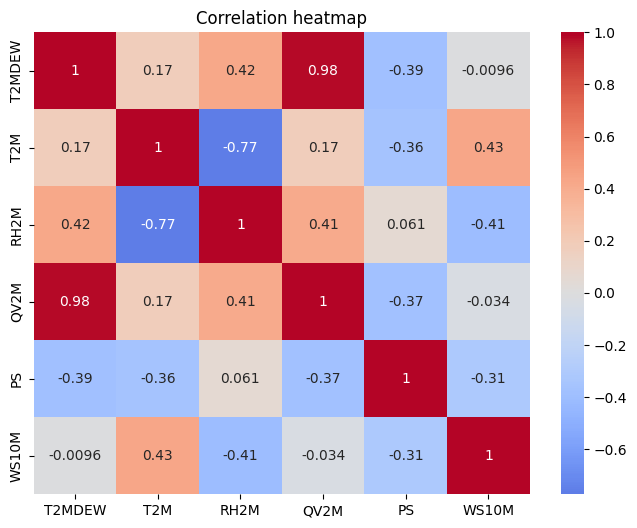

In [ ]:
cols = ["T2MDEW", "T2M", "RH2M", "QV2M", "PS", "WS10M"]
corr = df[cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation heatmap")
plt.savefig("correlation.png", dpi=300, bbox_inches='tight')
plt.show()


**Interpretation** <br>
- T2MDEW & QV2M = 0.98: Dew point depends directly on water vapor in the air. When QV2M increases so dew point increases. <br>
- T2MDEW & RH2M = 0.43 : As relative humidity increases, the air is closer to saturation and dew point rises. <br>
- T2MDEW & T2M = +0.16 :Temperature affects dew point slightly (warmer air can hold more vapor), but not as directly as humidity or vapor content. <br>                          
- T2MDEW & PS = -0.38 : Pressure doesn’t directly control condensation but might reflect altitude or weather system effects <br>                                               
- T2MDEW & WS10M = -0.017 : Wind has little direct linear effect on dew point, though strong wind can prevent dew by mixing air layers. <br>                                         
- RH2M & T2M = -0.78 : When air temperature increases, relative humidity decreases warm air holds more vapor, reducing RH if moisture doesn’t rise accordingly.

## Daily and Seasonal Cycle Graphs

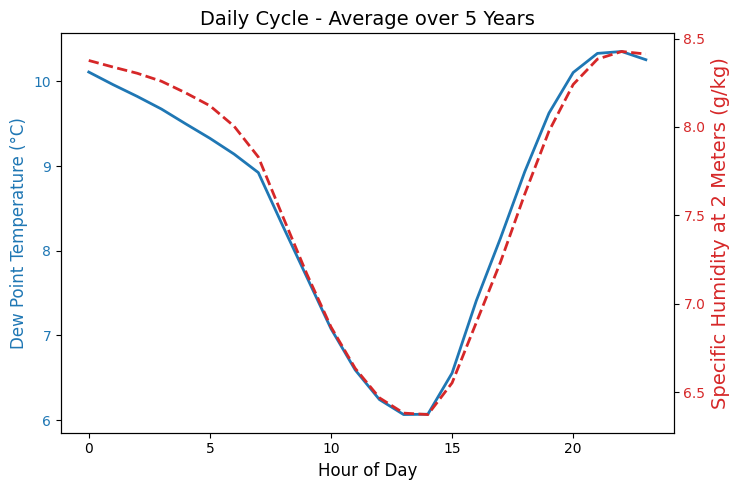

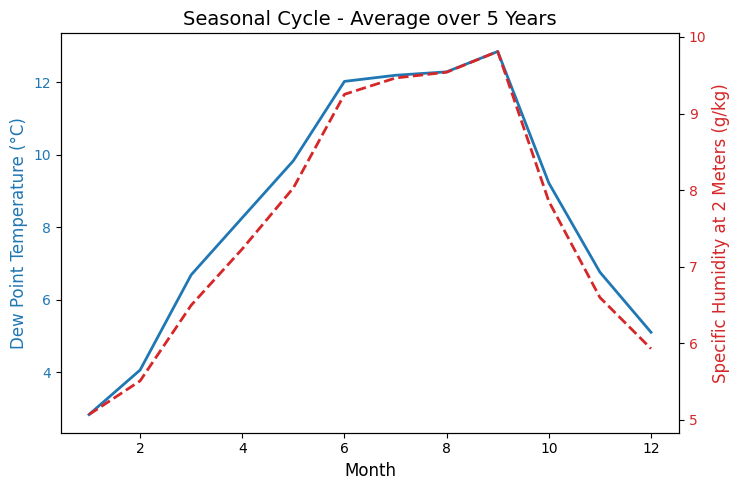

In [ ]:
import matplotlib.pyplot as plt

#Average by hour of day (across all years)
hourly = df.groupby("HR")[["T2MDEW", "QV2M"]].mean()

#Average by month (across all years)
monthly = df.groupby("MO")[["T2MDEW", "QV2M"]].mean()

#Plot: Daily cycle
fig, ax1 = plt.subplots(figsize=(7.5, 5.0))
color1 = 'tab:blue'
ax1.set_title("Daily Cycle - Average over 5 Years", fontsize=14)
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Dew Point Temperature (°C)", color=color1, fontsize=12)
ax1.plot(hourly.index, hourly["T2MDEW"], color=color1, linewidth=2, label="T2MDEW")
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Specific Humidity at 2 Meters (g/kg)", color=color2, fontsize=14)
ax2.plot(hourly.index, hourly["QV2M"], color=color2, linewidth=2, linestyle='--', label="QV2M")
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()

#Plot: Seasonal cycle
fig, ax1 = plt.subplots(figsize=(7.5, 5.0))
color1 = 'tab:blue'
ax1.set_title("Seasonal Cycle - Average over 5 Years", fontsize=14)
ax1.set_xlabel("Month", fontsize=12)
ax1.set_ylabel("Dew Point Temperature (°C)", color=color1, fontsize=12)
ax1.plot(monthly.index, monthly["T2MDEW"], color=color1, linewidth=2, label="T2MDEW")
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Specific Humidity at 2 Meters (g/kg)", color=color2, fontsize=12)
ax2.plot(monthly.index, monthly["QV2M"], color=color2, linewidth=2, linestyle='--', label="QV2M")
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.savefig("daily_seasonal_cycle.png", dpi=300, bbox_inches='tight')
plt.show()


**Data Interpretation**<br>
- Figure 1:  
-From midnight to early morning (0–6 h): Dew point and specific humidity decrease slowly, indicating cooling and slight drying as the atmosphere loses heat and moisture condensation increases.<br>
-Between morning (6–12 h): Sharp decline in both variables the air warms up, relative humidity drops, and dew point falls to its minimum around 13–15 h. This matches typical daytime heating and lower moisture content.<br>
-From afternoon to night (15–23 h): Both rise again, peaking at night due to radiative cooling, moisture recovery, and reduced mixing. <br>
=> Correlation: The two lines are tightly coupled when dew point drops, so does specific humidity. This indicates a strong relationship between atmospheric moisture content and temperature cycle, we have less specefic humidity and less water harvesting when dew point temperature is low <br>

- Figure 2:  <br>
-From January to August, both dew point and specific humidity increase steadily.This indicates a progressive warming and moistening of the atmosphere, likely associated with the wet or warm season. <br>
-Peak in August–September: Both reach their maximum, suggesting highest moisture content and temperature typical of the warm season or monsoon influence.<br>
-From October to December: Both variables decline sharply, indicating dry and cooler conditions as the atmosphere loses moisture.<br>
=>The close overlap between the two curves shows that specific humidity responds linearly and strongly to dew point variations.

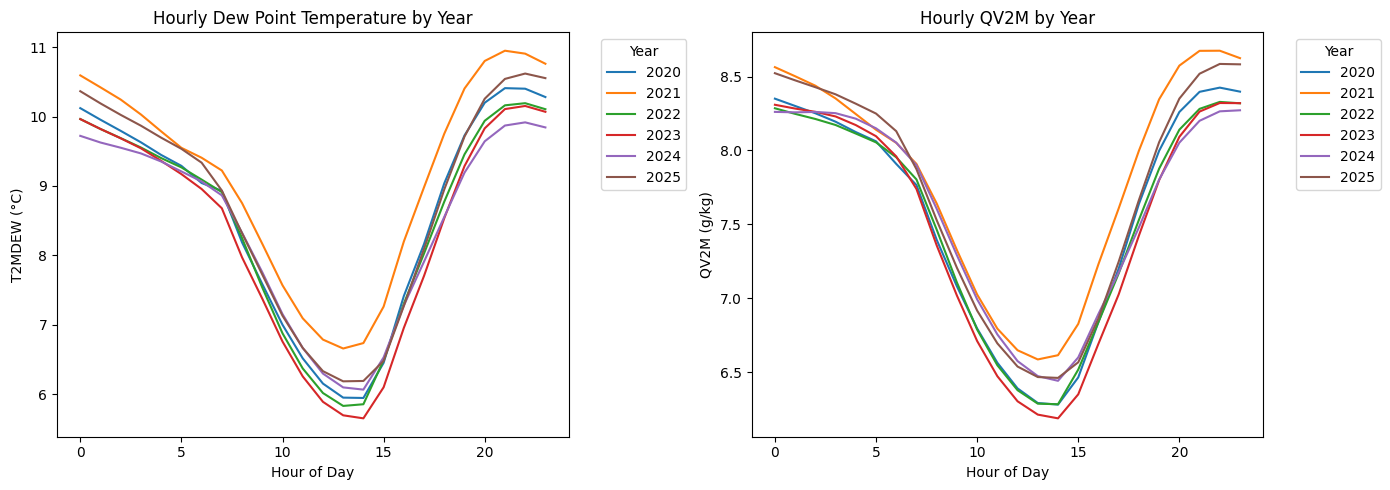

In [ ]:
import matplotlib.pyplot as plt

#Group by year and hour
hourly_by_year = df.groupby(["YEAR", "HR"])[["T2MDEW", "QV2M"]].mean().reset_index()

years = sorted(df["YEAR"].unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Dew Point Temperature
for y in years:
    data = hourly_by_year[hourly_by_year["YEAR"] == y]
    axes[0].plot(data["HR"], data["T2MDEW"], label=str(y))
axes[0].set_title("Hourly Dew Point Temperature by Year")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("T2MDEW (°C)")
axes[0].legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")

#QV2M
for y in years:
    data = hourly_by_year[hourly_by_year["YEAR"] == y]
    axes[1].plot(data["HR"], data["QV2M"], label=str(y))
axes[1].set_title("Hourly QV2M by Year")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("QV2M (g/kg)")
axes[1].legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("hourly_T2MDEW_QV2M.png", dpi=300, bbox_inches='tight')
plt.show()


**Interpretation** <br>
-Highest values at night / early morning (00:00-06:00) : Nights are cooler -> air holds more moisture -> dew point and QV2M increase <br>
-Lowest values in the afternoon (12:00–15:00) : Sun heats the air -> moisture decreases -> dew point and QV2M drop <br>
-Values go up again in the evening (17:00–22:00): Air cools -> moisture increases again <br>
-2021 and 2025 are the most humid years : Their lines are always higher than other years higher dew point & higher QV2M = more moisture in the air <br>
-2023 and 2024 are the driest years : their curves sit lower, especially during the afternoon & shows drier conditions that year <br>
-2020 and 2022 are moderate, in the middle



## Heatmap of Hour vs Day of Year

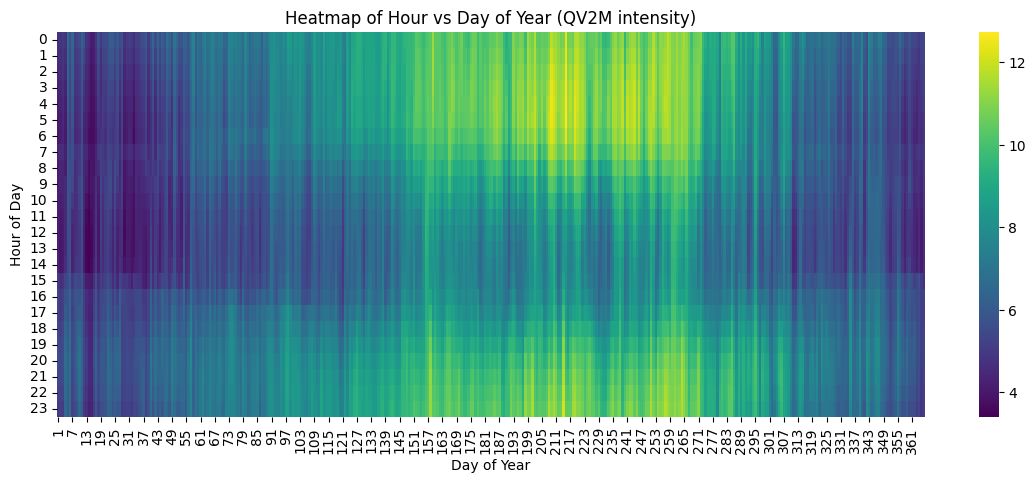

In [ ]:
df["dayofyear"] = df.index.dayofyear
pivot = df.pivot_table(index="HR", columns="dayofyear", values="QV2M", aggfunc="mean")
plt.figure(figsize=(14,5))
sns.heatmap(pivot, cmap="viridis")
plt.title("Heatmap of Hour vs Day of Year (QV2M intensity)")
plt.xlabel("Day of Year")
plt.ylabel("Hour of Day")
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


**Interpretation** <br>
-Humidity is highest at night and early morning (yellow/green colors at the top)<br>
-Humidity is lowest in the afternoon (blue colors around 12:00–16:00)<br>
-The middle of the year (summer) shows the highest overall humidity (more yellow)<br>
-The beginning and end of the year (winter) show lower humidity (more blue)<br>

## Monthly distribution of specific humidity (QV2M) for the Benguerir region

In [ ]:
# Make sure the date column is in datetime format
df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MO'].astype(str) + '-' + df['DY'].astype(str) + ' ' + df['HR'].astype(str) + ':00:00')

df['Month'] = df['Date'].dt.month_name().str[:3]  # 'Jan', 'Feb', etc.

#monthly average of main variables
monthly_mean = (
    df.groupby('Month')[['QV2M', 'T2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M']]
    .mean()
    .reset_index()
)

#Sort months in correct order
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_mean['Month'] = pd.Categorical(monthly_mean['Month'], categories=month_order, ordered=True)
monthly_mean = monthly_mean.sort_values('Month')

fig = px.line_polar(
    monthly_mean,
    r='QV2M',
    theta='Month',
    line_close=True,
    color_discrete_sequence=['royalblue'],
    title='Monthly distribution of QV2M(g/kg)'
)
plt.savefig("monthly_distribution_QV2M.png", dpi=300, bbox_inches='tight')
fig.show()


<Figure size 640x480 with 0 Axes>

**Data Interpretation** <br>
-Peak values (presaue 8–9 g/kg) occur between June and September, coinciding with the warmest period of the year. <br>
-Minimum values (presaue 5–6 g/kg) are observed between December and February, when lower temperatures reduce the air’s saturation capacity and surface evaporation is limited

# Linear Regression: prediction of T2MDEW

## Model Training

In [ ]:
#Features and target
X = df[["T2M", "RH2M", "QV2M", "PS", "WS10M"]]
y = df["T2MDEW"]

#Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

## Model Evaluation

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R²: 0.967
RMSE: 0.949


**Data Interpretation** <br>
-R²=0.967 means that the predicted dew points follow the actual physical variations almost perfectly; only 3.3% of the changes remain unexplained (likely due to random noise or unmodeled factors). This indicates a very strong relationship between the predictors (temperature, relative humidity, water vapor,...) and the target (dew point).<br>
-RMSE = 0.948°C real-world measure (in °C) that the model predicts

## Results Visualization

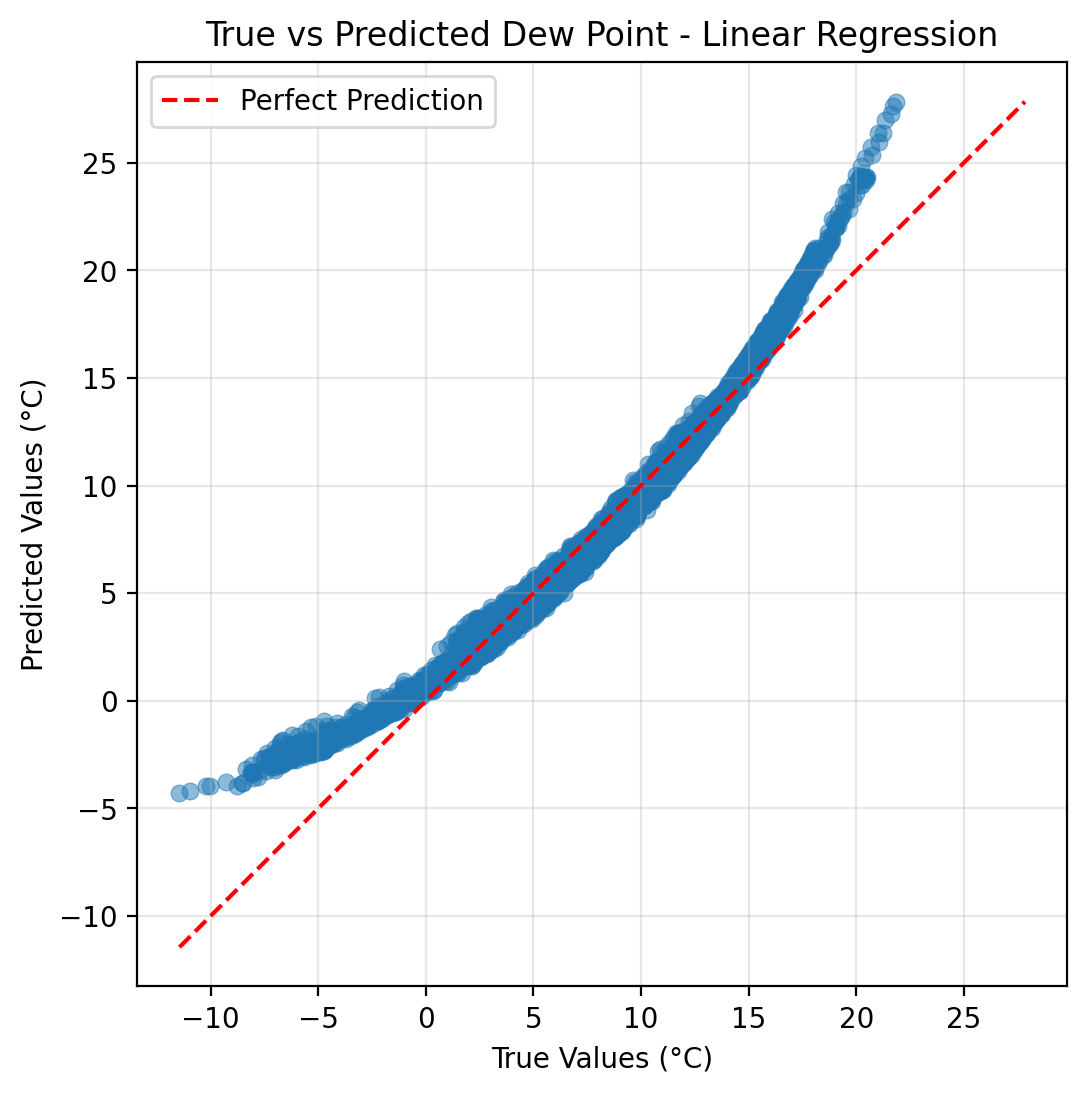

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)

lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', label='Perfect Prediction')

plt.xlabel("True Values (°C)")
plt.ylabel("Predicted Values (°C)")
plt.title("True vs Predicted Dew Point - Linear Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.axis("equal")
plt.savefig("linear_regression_prediction.png", dpi=300, bbox_inches='tight')
plt.show()


**Data Interpretation** <br>
-Perfect prediction line is when Predicted Dew Point = True Dew Point <br>
-Data points that are above(au-dessus) the red line -> the model overestimates (predicts too high) <br>
-Data points that are below the line -> it underestimates (predicts too low)

# Prophet Model

## Cross Validation: to check if the model is good by testing it many times on different parts of the data

In [ ]:
!pip install --upgrade prophet

In [ ]:
df_num = df.select_dtypes(include=['number'])

# Aggregate to monthly means
df_monthly = df_num.resample('ME').mean()

# Prepare Prophet format
prophet_df = df_monthly[['QV2M']].reset_index().rename(
    columns={'index':'ds', 'QV2M':'y'}
)

# Fit Prophet model
m = Prophet(
    yearly_seasonality=True,
    daily_seasonality=True,   # optional for monthly data
    weekly_seasonality=False
)
m.fit(prophet_df)

df_cv = cross_validation(
    model=m,
    initial="1095 days",   # 3 years training
    horizon="90 days",     # predict 3 months ahead
    period="30 days"       # new fold every 1 month
)

# Performance metrics for all folds
df_perf = performance_metrics(df_cv)
df_perf


INFO:prophet:Making 30 forecasts with cutoffs between 2023-02-13 00:00:00 and 2025-07-02 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,0.466497,0.683006,0.606504,0.075652,0.057761,0.077427,0.000000
1,21 days,0.900137,0.948755,0.797704,0.117362,0.102436,0.113052,0.000000
2,22 days,0.922594,0.960518,0.845374,0.141938,0.111294,0.134752,0.000000
3,23 days,0.896805,0.946998,0.806743,0.138547,0.111294,0.131525,0.222222
4,24 days,0.832020,0.912151,0.764566,0.130770,0.111294,0.122975,0.222222
5,25 days,0.600028,0.774615,0.650785,0.101529,0.089545,0.096590,0.333333
6,26 days,0.975402,0.987624,0.754134,0.094679,0.088317,0.099277,0.444444
7,27 days,1.032277,1.016010,0.809017,0.105327,0.088317,0.109406,0.444444
8,28 days,0.991122,0.995551,0.762389,0.112130,0.088317,0.113827,0.555556
9,29 days,0.739690,0.860052,0.632866,0.095589,0.072652,0.095711,0.629630


## Train and Evaluate Prophet Model

In [ ]:
!pip install --upgrade prophet cmdstanpy --quiet

In [ ]:
!python -m cmdstanpy.install_cmdstan --yes

<frozen runpy>:128: RuntimeWarning: 'cmdstanpy.install_cmdstan' found in sys.modules after import of package 'cmdstanpy', but prior to execution of 'cmdstanpy.install_cmdstan'; this may result in unpredictable behaviour
usage: install_cmdstan [-h] [--interactive] [--version VERSION] [--dir DIR]
                       [--overwrite] [--verbose] [--progress] [--cores CORES]
install_cmdstan: error: unrecognized arguments: --yes


In [ ]:
warnings.filterwarnings("ignore")
logging.getLogger("cmdstanpy").disabled = True
logging.getLogger("prophet").disabled = True

def prophet_score(dataset, target_col, test_size=0.2, frequency="M"):
    #Aggregate and interpolate
    df = dataset.select_dtypes(include=[np.number])
    df = df.resample(rule=frequency).mean().interpolate(method="time")

    #Prepare for Prophet
    prophet_df = pd.DataFrame({
        "ds": df.index,
        "y": df[target_col].values
    })

    #Train/test split
    split_idx = int(len(prophet_df) * (1 - test_size))
    train = prophet_df.iloc[:split_idx]
    test = prophet_df.iloc[split_idx:]

    #Train Prophet
    model = Prophet(yearly_seasonality=True)
    model.fit(train)

    #Forecast on test period
    future = model.make_future_dataframe(periods=len(test), freq=frequency)
    forecast = model.predict(future)

    #Align predictions with test dates
    forecast_test = forecast.set_index("ds").loc[test["ds"], "yhat"]

    #Compute metrics
    y_true = test["y"].values
    y_pred = forecast_test.values

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {"model": model, "forecast_full": forecast, "forecast_test": forecast_test,
            "test_df": test.reset_index(), "metrics": {"r2": r2, "mae": mae, "rmse": rmse}}


In [ ]:
def plot_prophet_radar(metrics):
    #Metric names and values
    labels = list(metrics.keys())
    values = list(metrics.values())

    #Normalize to 0–1 range for visual comparability
    norm_values = []
    for k, v in metrics.items():
        if k in ['mae', 'rmse']:
            # invert so that lower error = higher score
            norm_values.append(1 / (1 + v))
        else:
            norm_values.append(v)

    #Close the radar polygon
    values = norm_values + norm_values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    #Radar chart
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    #Plot
    ax.plot(angles, values, linewidth=2, color='steelblue')
    ax.fill(angles, values, color='steelblue', alpha=0.4)

    #Aesthetics
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=9)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9, fontweight='bold')
    ax.set_title("Prophet Forecast Performance", fontsize=9, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()


### Evaluation of QV2M

R² Score: 0.802
MAE: 0.601
RMSE: 0.830


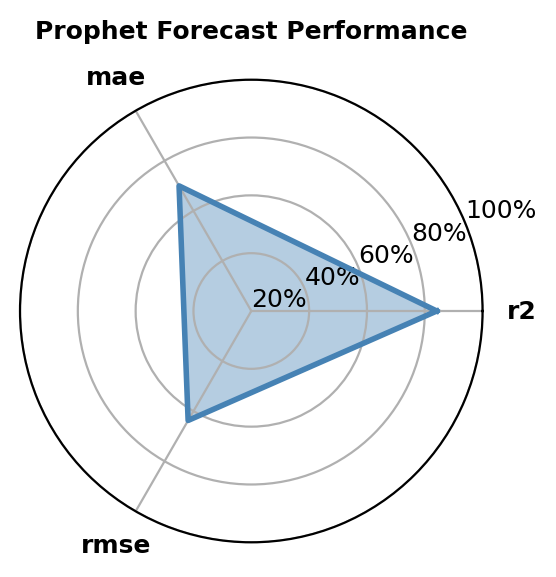

<Figure size 640x480 with 0 Axes>

In [ ]:
results_metrics=prophet_score(dataset=df, target_col='QV2M')
r2_QV2M_prophet = results_metrics["metrics"]["r2"]
mae_QV2M_prophet = results_metrics["metrics"]["mae"]
rmse_QV2M_prophet = results_metrics["metrics"]["rmse"]
print(f"R² Score: {r2_QV2M_prophet:.3f}")
print(f"MAE: {mae_QV2M_prophet:.3f}")
print(f"RMSE: {rmse_QV2M_prophet:.3f}")
results = prophet_score(dataset=df, target_col='QV2M')
plot_prophet_radar(results["metrics"])
plt.savefig("prophet_QV2M_evaluation.png", dpi=300, bbox_inches='tight')

**Data Interpretation** <br>
Model understands well 80% of relationship between time and QV2M and the model coudn't predict 20% of data maybe because noises or outliers, etc.

### Evaluation of T2MDEW


R² Score: 0.763
MAE: 1.468
RMSE: 1.913


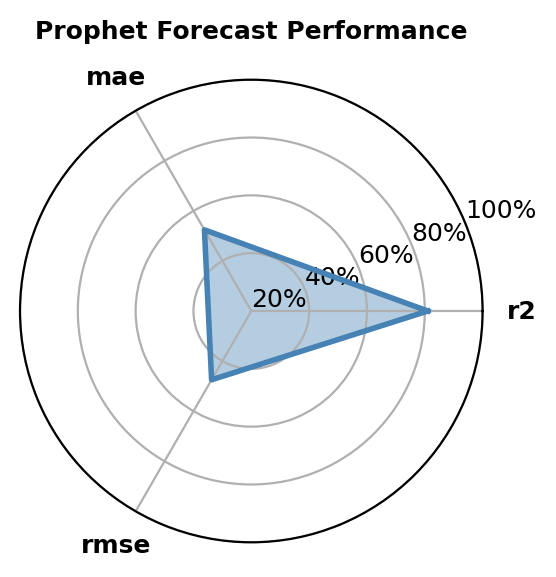

<Figure size 640x480 with 0 Axes>

In [ ]:
results_metrics=prophet_score(dataset=df, target_col='T2MDEW')
r2_T2MDEW_prophet = results_metrics["metrics"]["r2"]
mae_T2MDEW_prophet = results_metrics["metrics"]["mae"]
rmse_T2MDEW_prophet = results_metrics["metrics"]["rmse"]
print(f"R² Score: {r2_T2MDEW_prophet:.3f}")
print(f"MAE: {mae_T2MDEW_prophet:.3f}")
print(f"RMSE: {rmse_T2MDEW_prophet:.3f}")

results = prophet_score(dataset=df, target_col='T2MDEW')
plot_prophet_radar(results["metrics"])
plt.savefig("prophet_T2MDEW_evaluation.png", dpi=300, bbox_inches='tight')

**Data Interpretation** <br>
-R² is the strongest score (about 80%) it means that Prophet captures the overall trend and seasonal patterns very well <br>
-MAE and RMSE are moderate (around 35–40%) it means Prophet makes some forecasting errors, meaning it sometimes misses short-term variations

## Forcasting of QV2M for The Future 5 years using Prophet Model

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def sktime_forecast(dataset, horizon=60, frequency="M"):

    #Aggregate to monthly
    forecast_df = dataset.resample(rule=frequency).mean()

    #Fill any missing timestamps
    forecast_df = forecast_df.interpolate(method="time")

    all_results = {}
    units = {
        "QV2M": "g/kg",
        "T2MDEW": "°C",
    }

    for col in forecast_df.columns:
        df = forecast_df[col].dropna()

        #Prepare Prophet input format
        prophet_df = pd.DataFrame({
            'ds': df.index,
            'y': df.values
        })

        #Initialize Prophet
        model = Prophet(yearly_seasonality=True, weekly_seasonality=False)
        model.fit(prophet_df)

        #Extend into the future (60 months = 5 years)
        future = model.make_future_dataframe(periods=horizon, freq=frequency)
        forecast = model.predict(future)

        #Separate the forecast (only future values)
        future_forecast = forecast[forecast['ds'] > prophet_df['ds'].max()]

        #Plot results
        plt.figure(figsize=(12, 6))
        plt.style.use('default')
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 1.0

        #Actual historical data (black)
        plt.plot(prophet_df['ds'], prophet_df['y'], color='black', label='Actual')

        #Future forecast (blue)
        plt.plot(future_forecast['ds'], future_forecast['yhat'], color='blue', label='Forecast')

        #Titles and labels
        unit = units.get(col, "")
        plt.title(f"Forecast for {col} in next 5years")
        plt.xlabel("Date")
        plt.ylabel(f"{col} ({unit})" if unit else col)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"prophet_{col}_forcasting.png", dpi=300, bbox_inches='tight')
        plt.show()

        all_results[col] = {
            "prophet_df": prophet_df,
            "forecast": forecast,
            "future_forecast": future_forecast
        }
    return all_results

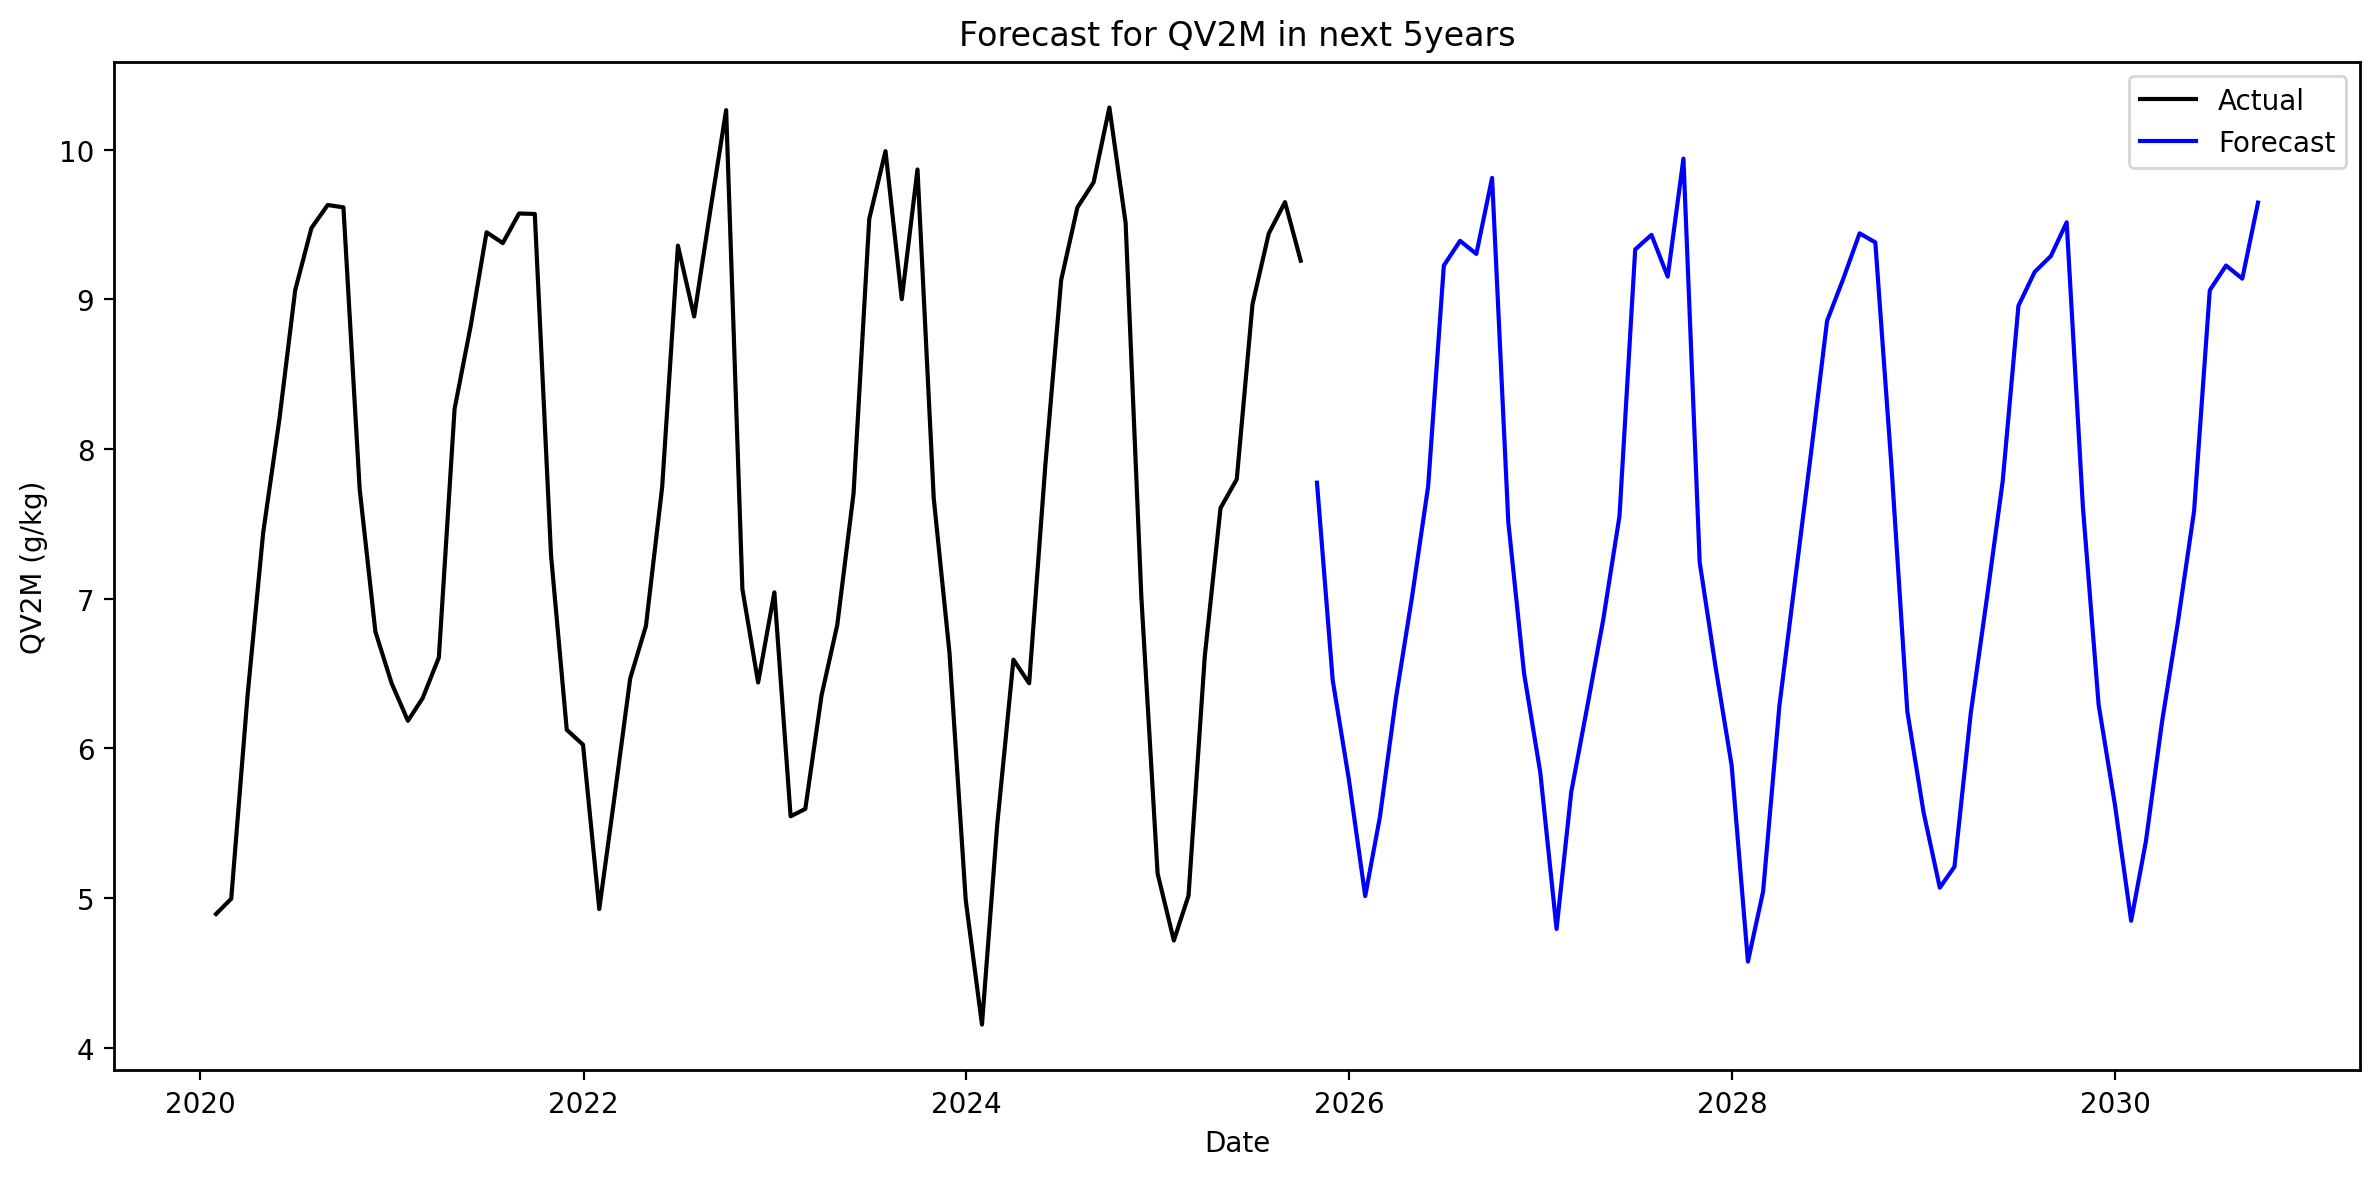

In [ ]:
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=False)
results = sktime_forecast(dataset=df[['QV2M']], horizon=60, frequency="M"); #60months means 5 years(1year=12months)

**Data Interpretation** <br>
-QV2M rises to 9–10 g/kg every year around June –> September <br>
-The historical period (2020-2025) and the forecast period (2025-2030) both demonstrate a clear annual cycle, with specific humidity values between approximately 4 and 10 g/kg. This reflects the natural alternation between wet and dry seasons within the BenGuerir region <br>

### Table of values of QV2M

In [ ]:
#Extract Prophet results
prophet_df = results['QV2M']['prophet_df']
future_forecast = results['QV2M']['future_forecast']

#Table for Actual (historical data)
actual_table = prophet_df.rename(columns={"y": "Actual"})[["ds", "Actual"]]
actual_table["Year"] = actual_table["ds"].dt.year
actual_table["Month"] = actual_table["ds"].dt.month_name()

#Table for Forecasted (future data)
forecast_table = future_forecast.rename(columns={"yhat": "Forecast"})[["ds", "Forecast"]]
forecast_table["Year"] = forecast_table["ds"].dt.year
forecast_table["Month"] = forecast_table["ds"].dt.month_name()

#Display both
print("Actual (Historical) Data:")
display(actual_table.head(10))

print("Forecasted (Predicted) Data:")
display(forecast_table.head(10))


Actual (Historical) Data:


,ds,Actual,Year,Month
0,2020-01-31,4.892823,2020,January
1,2020-02-29,4.994957,2020,February
2,2020-03-31,6.347245,2020,March
3,2020-04-30,7.443264,2020,April
4,2020-05-31,8.202191,2020,May
5,2020-06-30,9.061681,2020,June
6,2020-07-31,9.476694,2020,July
7,2020-08-31,9.630578,2020,August
8,2020-09-30,9.614861,2020,September
9,2020-10-31,7.731788,2020,October


Forecasted (Predicted) Data:


,ds,Forecast,Year,Month
69,2025-10-31,7.774963,2025,October
70,2025-11-30,6.454873,2025,November
71,2025-12-31,5.788824,2025,December
72,2026-01-31,5.012568,2026,January
73,2026-02-28,5.540402,2026,February
74,2026-03-31,6.344447,2026,March
75,2026-04-30,7.004214,2026,April
76,2026-05-31,7.749200,2026,May
77,2026-06-30,9.226109,2026,June
78,2026-07-31,9.390960,2026,July


## Forcasting of T2MDEW for The Future 5 years using Prophet Model

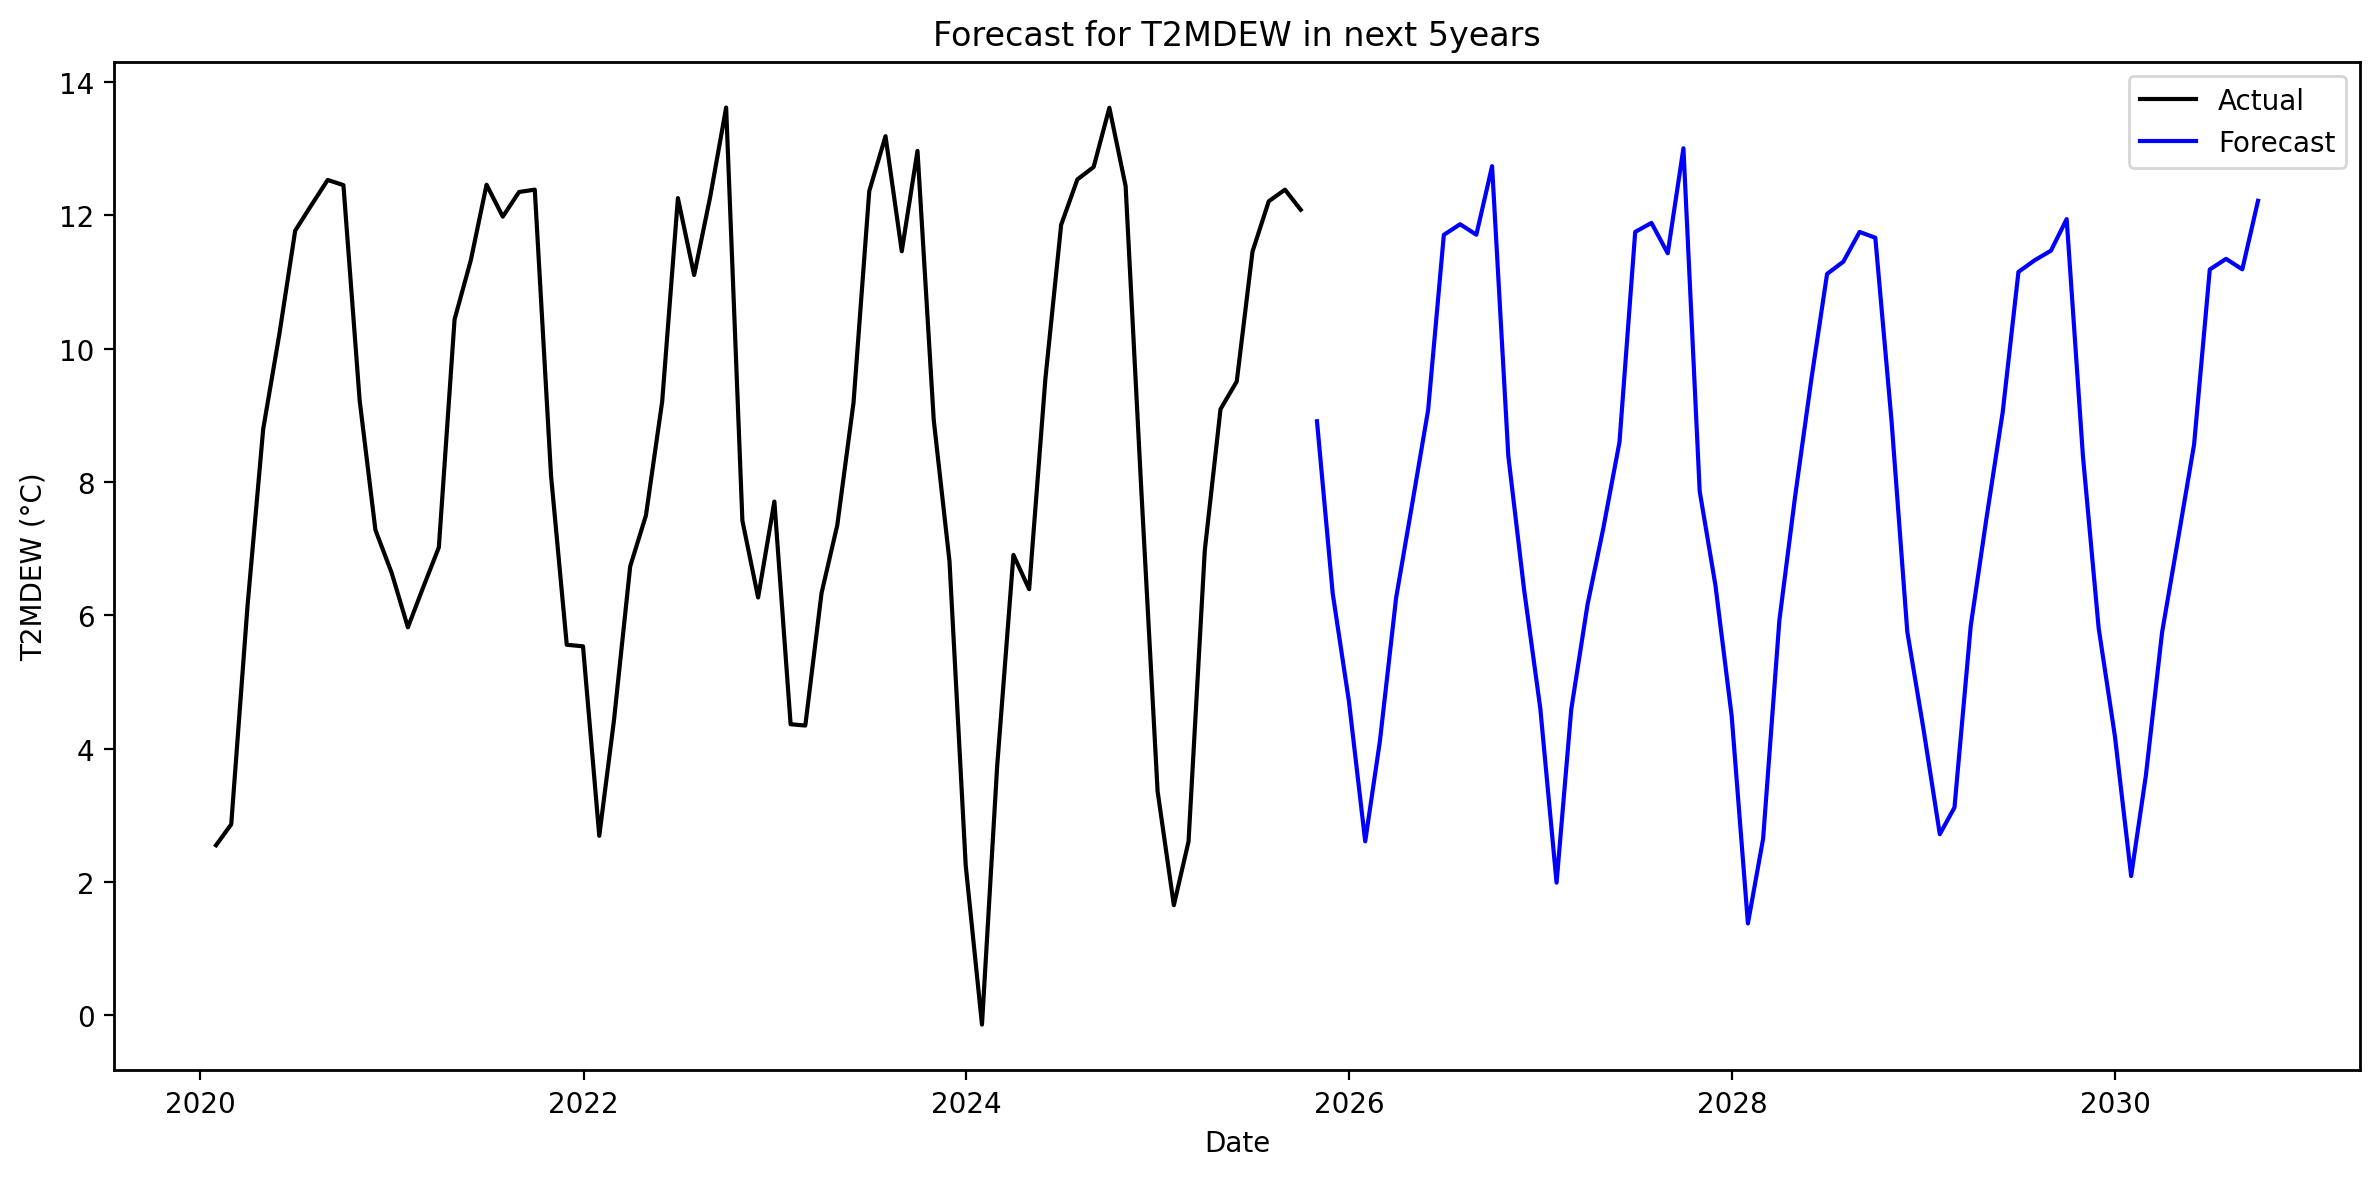

In [ ]:
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=False)
results = sktime_forecast(dataset=df[['T2MDEW']], horizon=60, frequency="M"); #60months means 5 years(1year=12months)

**Data Interpretation** <br>
-Dew point rises to 12–14°C in late summer and early autumn <br>
-The historical T2MDEW series displays a clear annual cycle, with dew point temperatures increasing during warm months and decreasing during cooler periods <br>
-The predicted values maintain the same amplitude and timing as the historical data, indicating stable and persistent seasonal moisture patterns across years <br>
-Winter: December–January–February -> cold -> low dew point <br>
-Summer: June–July–August -> hot -> high dew point

### Table of values of T2MDEW

In [ ]:
#Extract Prophet results
prophet_df = results['T2MDEW']['prophet_df']
future_forecast = results['T2MDEW']['future_forecast']

#Table for Actual (historical data)
actual_table = prophet_df.rename(columns={"y": "Actual"})[["ds", "Actual"]]
actual_table["Year"] = actual_table["ds"].dt.year
actual_table["Month"] = actual_table["ds"].dt.month_name()

#Table for Forecasted (future data)
forecast_table = future_forecast.rename(columns={"yhat": "Forecast"})[["ds", "Forecast"]]
forecast_table["Year"] = forecast_table["ds"].dt.year
forecast_table["Month"] = forecast_table["ds"].dt.month_name()

# Display both
print("Actual (Historical) Data:")
display(actual_table.head(10))

print("Forecasted (Predicted) Data:")
display(forecast_table.head(10))


Actual (Historical) Data:


,ds,Actual,Year,Month
0,2020-01-31,2.552110,2020,January
1,2020-02-29,2.866810,2020,February
2,2020-03-31,6.136855,2020,March
3,2020-04-30,8.797528,2020,April
4,2020-05-31,10.229113,2020,May
5,2020-06-30,11.772389,2020,June
6,2020-07-31,12.156532,2020,July
7,2020-08-31,12.533118,2020,August
8,2020-09-30,12.455194,2020,September
9,2020-10-31,9.222473,2020,October


Forecasted (Predicted) Data:


,ds,Forecast,Year,Month
69,2025-10-31,8.912973,2025,October
70,2025-11-30,6.330789,2025,November
71,2025-12-31,4.708715,2025,December
72,2026-01-31,2.610855,2026,January
73,2026-02-28,4.112765,2026,February
74,2026-03-31,6.266769,2026,March
75,2026-04-30,7.642718,2026,April
76,2026-05-31,9.081871,2026,May
77,2026-06-30,11.709569,2026,June
78,2026-07-31,11.868790,2026,July


C/C: Water harvesting is most favorable during months where Specific humidity (QV2M) peaks and Dew point temperature (T2MDEW) is high and Cooler nighttime temperatures allow condensation => water harvesting will be most effective between June -> October each year (2025–2030)

#LSTM Multivariate Model

### Cross validation to check how well the model perform on new unseen data

In [ ]:
#control randomness=freeze the randomness
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed) #control TensorFlow/Keras random generator
random.seed(seed) #control Python own random system

# Data preparation
df_nm = df.select_dtypes(include=["number"])#keeping only numeric columns
df_m = df_nm.resample("M").mean()

# Features and Targets
features = ["T2M", "T2MDEW", "T2MWET", "RH2M", "PRECTOTCORR","PS", "WS10M", "WD10M", "QV2M"]
target_vars = ["T2MDEW", "QV2M"]
n_targets = len(target_vars)
target_indices = [features.index(v) for v in target_vars]

# Scaling: data is between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_m[features].values)

# Sliding-Window Sequence
def create_sequences(data, input_steps, output_steps, target_indices):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps): #Loop over dataset to create all possible windows
        X.append(data[i : i + input_steps]) #Input window: Take 36 rows (months) and store them as one training sample
        future = data[i + input_steps : i + input_steps + output_steps, target_indices] #Output window: 12 future months and extract only target variables
        y.append(future)
    return np.array(X), np.array(y)

# Window lengths
input_steps = 36 # 36 months history=3years
output_steps = 12 # 12 months forecast

X, y = create_sequences(scaled_data, input_steps, output_steps, target_indices)

# Flatten y (samples, output_steps * n_targets)
y_flat = y.reshape(y.shape[0], -1)#reshape (future months(12),2 variables) to 1D vector with 24 values (12*2)

# LSTM Model Builder => so each CV fold will get an LSTM model
def build_model(input_steps, n_features, output_steps, n_targets):
    model = Sequential([
        LSTM(512, return_sequences=True, input_shape=(input_steps, n_features)),#return_sequence=True => pass full sequence to next LSTM
        Dropout(0.05),#dropout 10% of neurons to prevents overfitting

        LSTM(256, return_sequences=True),#256 units = LSTM memory cells = hidden units
        Dropout(0.05),

        LSTM(128),
        Dropout(0.05),

        Dense(64, activation="relu"),
        Dense(output_steps * n_targets)
    ])

    model.compile(optimizer="adam", loss="mse")
    return model

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)#5 folds
fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n Fold {fold+1} ")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_flat[train_idx], y_flat[test_idx]

    # Build a fresh LSTM model for each fold
    model = build_model(input_steps, len(features), output_steps, n_targets)

    # Train the model
    model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )

    # Predict and reshape output
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(-1, output_steps, n_targets)
    y_test_fold = y_test.reshape(-1, output_steps, n_targets)#Convert 24 values -> (12, 2)

    # Metrics for each variable
    fold_result = {"Fold": fold+1}

    for j, var in enumerate(target_vars):
        true = y_test_fold[:, :, j].flatten()
        pred = y_pred[:, :, j].flatten()

        r2 = r2_score(true, pred)
        rmse = np.sqrt(mean_squared_error(true, pred))
        mae = mean_absolute_error(true, pred)

        fold_result[f"{var}_R2"] = r2
        fold_result[f"{var}_RMSE"] = rmse
        fold_result[f"{var}_MAE"] = mae

        print(f"{var}: R2={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")

    fold_metrics.append(fold_result)

# Save results into a DataFrame
cv_results = pd.DataFrame(fold_metrics)
cv_results


/tmp/ipython-input-2122974870.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




 Fold 1 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
T2MDEW: R2=-1.2519, RMSE=0.4489, MAE=0.3901
QV2M: R2=-1.5124, RMSE=0.4759, MAE=0.4177

 Fold 2 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
T2MDEW: R2=0.2591, RMSE=0.2722, MAE=0.2177
QV2M: R2=0.2903, RMSE=0.2722, MAE=0.2254

 Fold 3 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
T2MDEW: R2=0.8910, RMSE=0.0991, MAE=0.0768
QV2M: R2=0.9080, RMSE=0.0963, MAE=0.0690

 Fold 4 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
T2MDEW: R2=0.8978, RMSE=0.0950, MAE=0.0751
QV2M: R2=0.9046, RMSE=0.0973, MAE=0.0704

 Fold 5 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
T2MDEW: R2=0.8701, RMSE=0.1053, MAE=0.0876
QV2M: R2=0.9105, RMSE=0.0925, MAE=0.0731


,Fold,T2MDEW_R2,T2MDEW_RMSE,T2MDEW_MAE,QV2M_R2,QV2M_RMSE,QV2M_MAE
0,1,-1.251904,0.448950,0.390086,-1.512418,0.475893,0.417740
1,2,0.259055,0.272191,0.217673,0.290306,0.272174,0.225396
2,3,0.890998,0.099147,0.076836,0.908012,0.096325,0.069048
3,4,0.897796,0.094991,0.075138,0.904595,0.097320,0.070392
4,5,0.870063,0.105327,0.087606,0.910540,0.092550,0.073087


In [ ]:
from tensorflow.keras.optimizers import Adam

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
df_nm = df.select_dtypes(include=['number'])

df_m = df_nm.resample("M").mean()

features = ["T2M","T2MDEW","T2MWET","RH2M","PRECTOTCORR","PS","WS10M","WD10M","QV2M"]

target_vars = ["T2MDEW", "QV2M"]
target_indices = [features.index(var) for var in target_vars]

data = df_m[features].values

#Scale data cz neural networks learn better when numbers are between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, input_steps, output_steps, target_indices):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i : i + input_steps])

        # y shape → (output_steps, n_targets)
        future = data[i + input_steps : i + input_steps + output_steps, target_indices]
        y.append(future)

    return np.array(X), np.array(y)


input_steps = 36 # 3 years history(36 months=3*12)
output_steps = 12 # 1 year forecast

#sliding-window
X, y = create_sequences(scaled_data, input_steps, output_steps, target_indices) #X -> past 60 days of all features and y -> next 30 days of QV2M only

y_flat = y.reshape(y.shape[0], -1)

split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y_flat[:split], y_flat[split:]

model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(input_steps, len(features))),#layer1 with 512 units
    Dropout(0.1),
    LSTM(256, return_sequences=True),#Layer2 contains 256 hidden units=neurons per layer
    Dropout(0.1),
    LSTM(128),#Layer3
    Dropout(0.1),
    Dense(64, activation='relu'),#Layer4 with 64 neurons
    Dense(output_steps* len(target_vars)) #Layer5 with 24 neurons: 12 months * 2 target variables=24 neurons
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    shuffle=False,
    verbose=1
)

/tmp/ipython-input-2211326793.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.4114 - val_loss: 0.3700
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - loss: 0.3331 - val_loss: 0.2442
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - loss: 0.2455 - val_loss: 0.1706
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - loss: 0.2043 - val_loss: 0.1453
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - loss: 0.1734 - val_loss: 0.1419
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step - loss: 0.1689 - val_loss: 0.1250
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1462 - val_loss: 0.1181
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step - loss: 0.1363 - val_loss: 0.1190
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1353 - val_loss: 0.1211
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step - loss: 0.1266 - val_loss: 0.1263
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - loss: 0.1230 - val_loss: 0.1192
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - loss: 0.1137 - v

In [ ]:
y_pred_scaled = model.predict(X_test)

n_targets = len(target_vars)

y_pred_scaled = y_pred_scaled.reshape(-1, output_steps, n_targets)
y_test_scaled = y_test.reshape(-1, output_steps, n_targets)

y_pred_inv = []
y_true_inv = []
metrics = {}

for j, var in enumerate(target_vars):

    idx = features.index(var)

    # Empty arrays for inverse transform
    temp_pred = np.zeros((y_pred_scaled.shape[0] * output_steps, len(features)))
    temp_true = np.zeros((y_test_scaled.shape[0] * output_steps, len(features)))

    # Fill values
    temp_pred[:, idx] = y_pred_scaled[:, :, j].flatten()
    temp_true[:, idx] = y_test_scaled[:, :, j].flatten()

    # Inverse transform
    pred_inv = scaler.inverse_transform(temp_pred)[:, idx]
    true_inv = scaler.inverse_transform(temp_true)[:, idx]

    y_pred_inv.append(pred_inv)
    y_true_inv.append(true_inv)

    # Metrics
    rmse = np.sqrt(mean_squared_error(true_inv, pred_inv))
    mae = mean_absolute_error(true_inv, pred_inv)
    r2 = r2_score(true_inv, pred_inv)

    metrics[var] ={
        "R2": r2,
        "RMSE": rmse,#exemple: T2MDEW => RMSE: 1.3684 means the prediction is wrong by about 1°C on average => exemple: If the real dew point is 12°C, the model predicts something like 11°C or 13°C
        "MAE": mae
    }

    print(f"{var} => R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
T2MDEW => R2: 0.6478, RMSE: 2.3979, MAE: 2.0059
QV2M => R2: 0.7377, RMSE: 0.9760, MAE: 0.7965


In [ ]:
def forecast_future_multi(model, last_sequence, scaler, target_vars, features,
                          output_steps, n_months):

    n_targets = len(target_vars)
    target_indices = [features.index(v) for v in target_vars]

    current_seq = last_sequence.copy()
    preds_scaled = []

    n_blocks = n_months // output_steps

    for _ in range(n_blocks):

        # Predict next block (flat)
        pred_block = model.predict(
            current_seq.reshape(1, current_seq.shape[0], current_seq.shape[1]),
            verbose=0
        )[0]  # shape: (12*2,)

        # Reshape to (12, 2)
        pred_block = pred_block.reshape(output_steps, n_targets)

        preds_scaled.append(pred_block)

        # build new_rows to feed into next sequence
        new_rows = np.zeros((output_steps, current_seq.shape[1]))

        for j, idx in enumerate(target_indices):
            new_rows[:, idx] = pred_block[:, j]

        # slide window
        current_seq = np.vstack([current_seq[output_steps:], new_rows])

    preds_scaled = np.vstack(preds_scaled)  # (60, 2)

    # Inverse transform for each variable separately
    preds_inv = {}
    for j, var in enumerate(target_vars):

        idx = features.index(var)

        temp = np.zeros((preds_scaled.shape[0], len(features)))
        temp[:, idx] = preds_scaled[:, j]

        preds_inv[var] = scaler.inverse_transform(temp)[:, idx]

    return preds_inv

last_sequence = scaled_data[-input_steps:]

forecast = forecast_future_multi(
    model=model,
    last_sequence=last_sequence,
    scaler=scaler,
    target_vars=target_vars, #["T2MDEW","QV2M"]
    features=features,
    output_steps=output_steps,# 12
    n_months=60 # 5 years
)

future_dates = pd.date_range(
    start=df_m.index[-1] + pd.DateOffset(months=1),
    periods=60,
    freq="M"
)

## Plot QV2M 5 year forecast

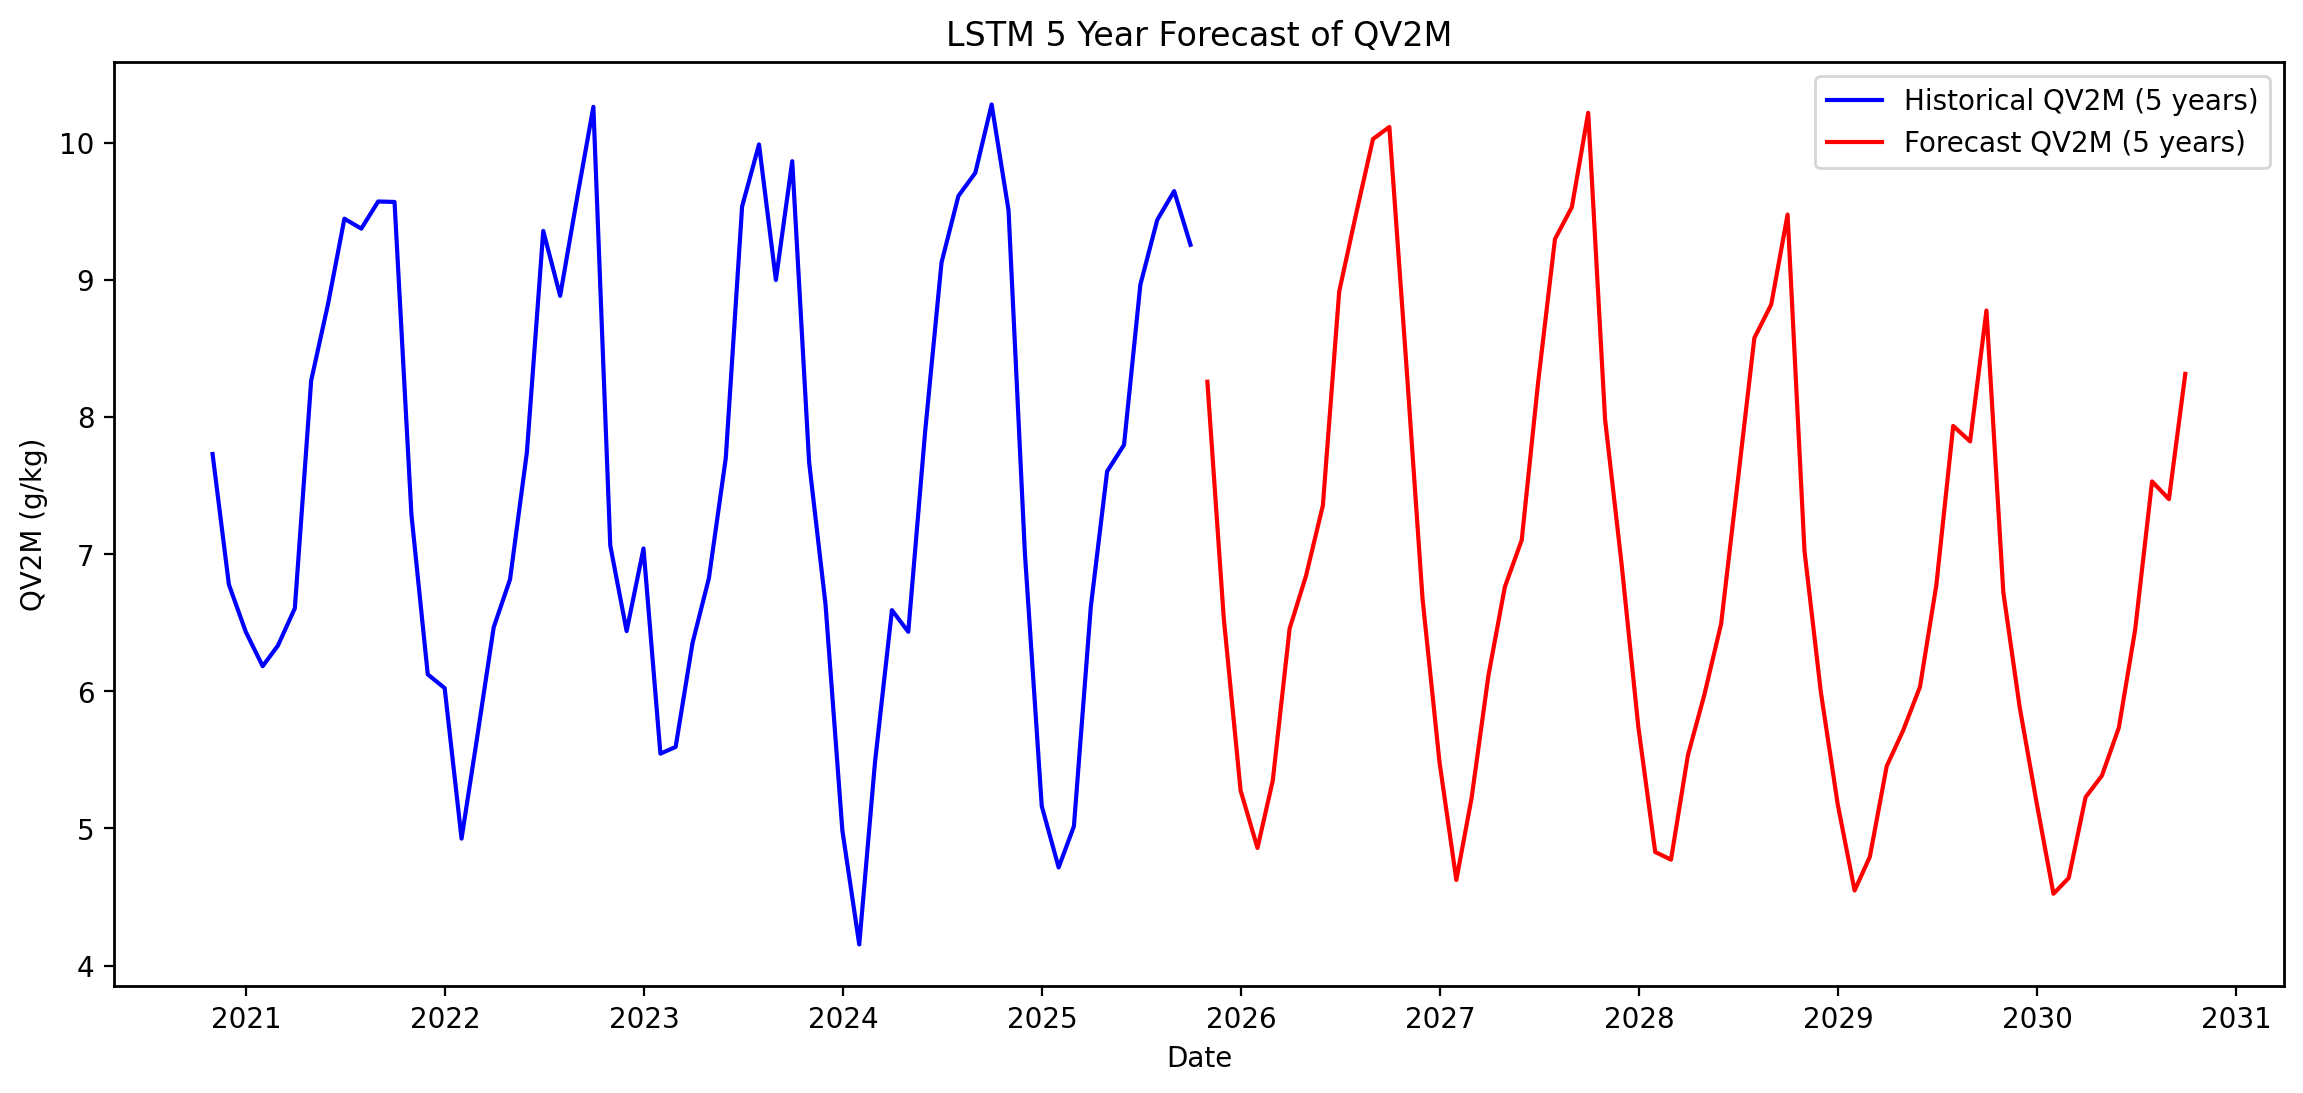

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_m.index[-60:], df_m["QV2M"][-60:], label="Historical QV2M (5 years)", color="blue")
plt.plot(future_dates, forecast["QV2M"], label="Forecast QV2M (5 years)", color="red")
plt.title("LSTM 5 Year Forecast of QV2M")
plt.xlabel("Date")
plt.ylabel("QV2M (g/kg)")
plt.legend()
plt.grid(False)
plt.show()

## Plot T2MDEW 5 year forecast

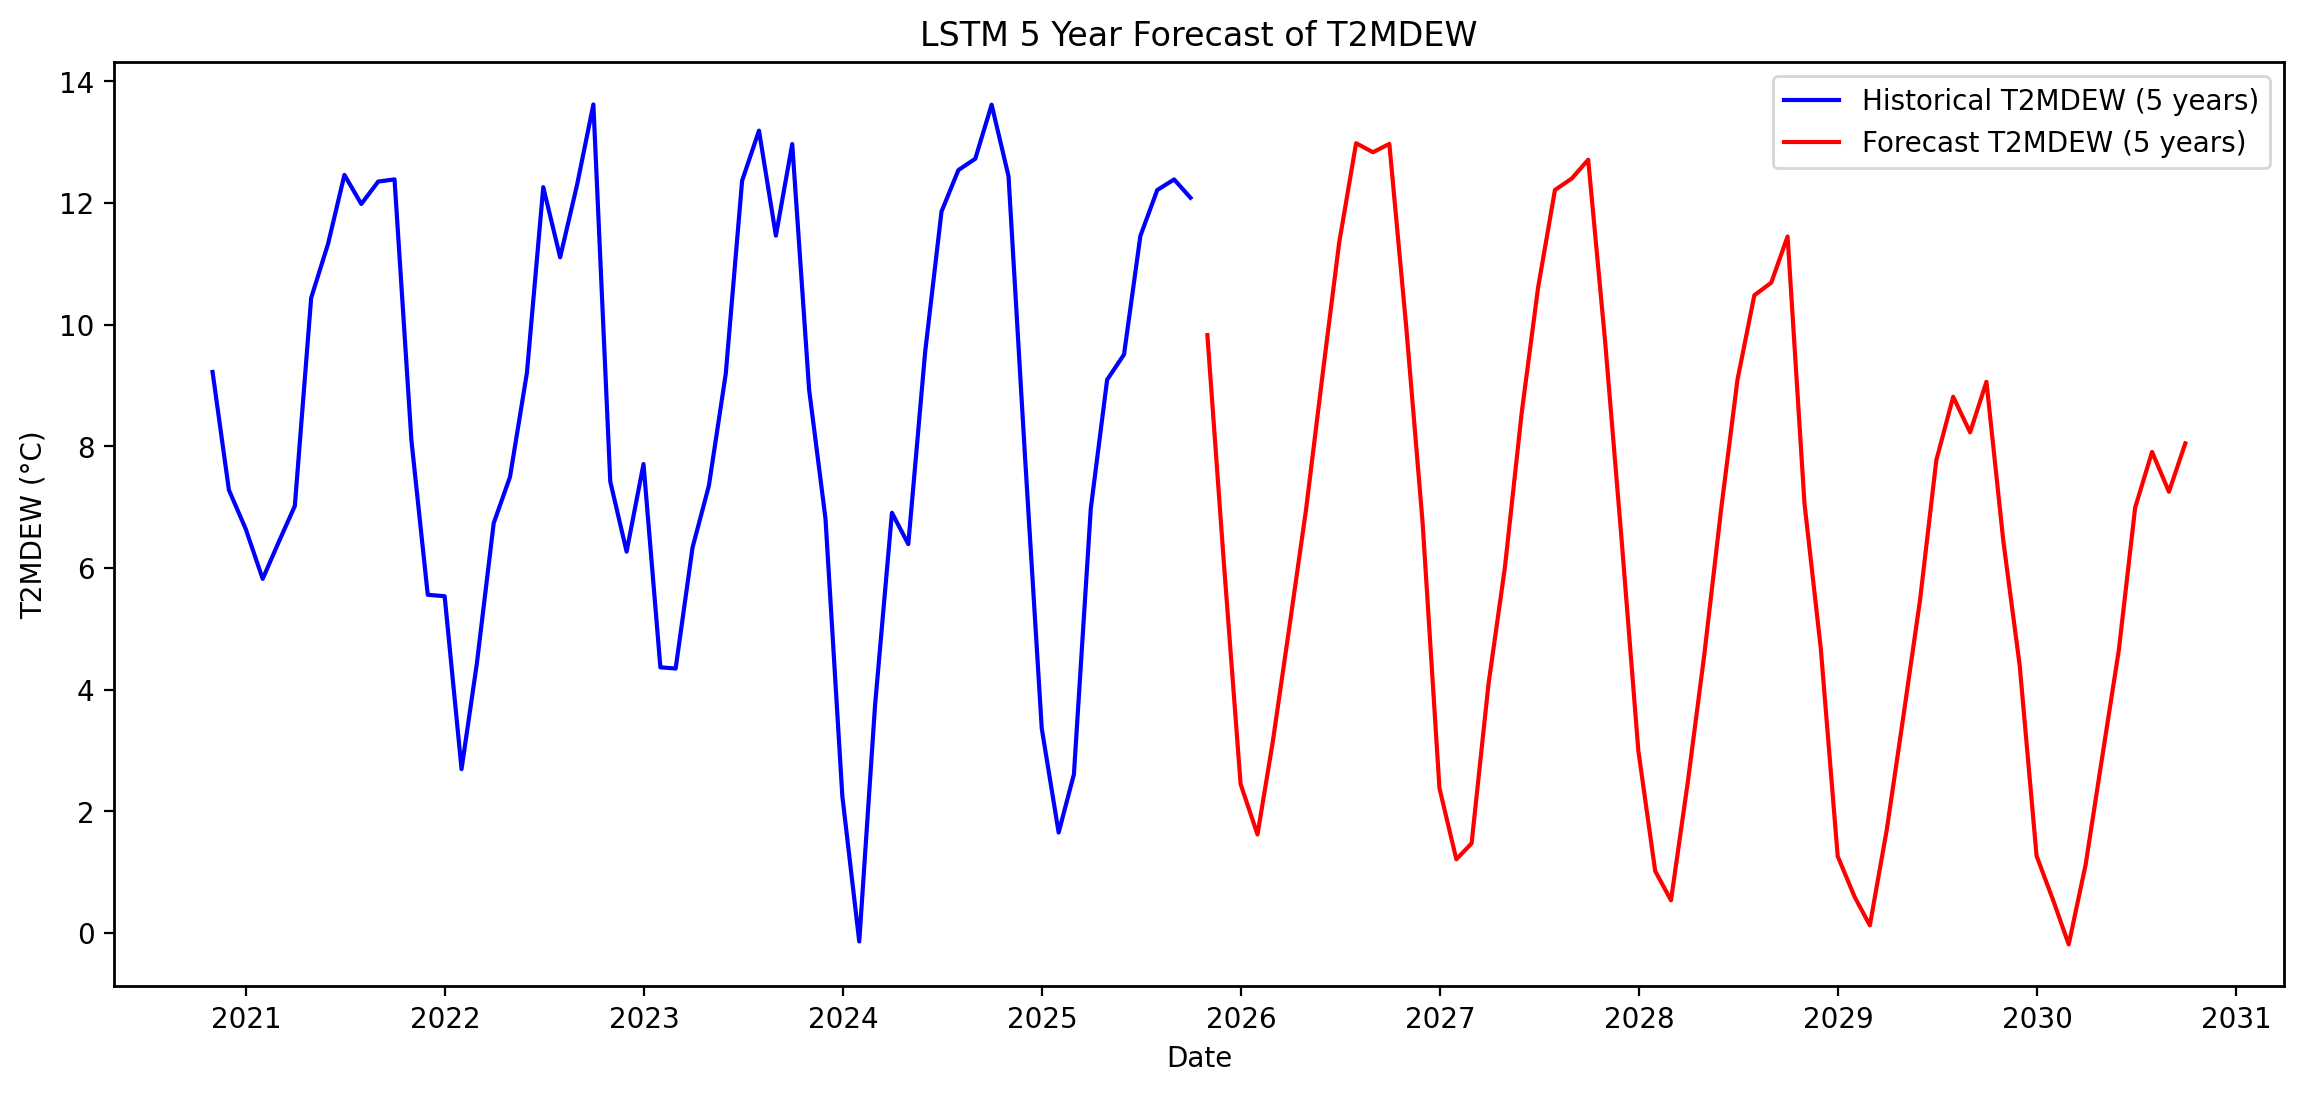

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_m.index[-60:], df_m["T2MDEW"][-60:], label="Historical T2MDEW (5 years)", color="blue")
plt.plot(future_dates, forecast["T2MDEW"], label="Forecast T2MDEW (5 years)", color="red")
plt.title("LSTM 5 Year Forecast of T2MDEW")
plt.xlabel("Date")
plt.ylabel("T2MDEW (°C)")
plt.legend()
plt.grid(False)
plt.show()

**Data Interpretation** <br>
-The historical QV2M curve (blue) shows a strong annual seasonal cycle, with peaks during
warm months and drops during colder periods. <br>
-The LSTM forecast (red) successfully reproduces this seasonal pattern over the next 5 years.
The predicted humidity values stay within the same realistic range as past observations,
which confirms that the model learned the long-term atmospheric behavior.

# Comparing Prophet and LSTM


In [ ]:
rows = []

# LSTM results for QV2M
rows.append({
    "Variable": "QV2M",
    "Model": "LSTM",
    "R2": metrics["QV2M"]["R2"],
    "MAE": metrics["QV2M"]["MAE"],
    "RMSE": metrics["QV2M"]["RMSE"],
})

# LSTM results for T2MDEW
rows.append({
    "Variable": "T2MDEW",
    "Model": "LSTM",
    "R2": metrics["T2MDEW"]["R2"],
    "MAE": metrics["T2MDEW"]["MAE"],
    "RMSE": metrics["T2MDEW"]["RMSE"],
})

# Prophet results for QV2M
rows.append({
    "Variable": "QV2M",
    "Model": "Prophet",
    "R2": r2_QV2M_prophet,
    "MAE": mae_QV2M_prophet,
    "RMSE": rmse_QV2M_prophet,
})

# Prophet for T2MDEW
rows.append({
    "Variable": "T2MDEW",
    "Model": "Prophet",
    "R2": r2_T2MDEW_prophet,
    "MAE": mae_T2MDEW_prophet,
    "RMSE": rmse_T2MDEW_prophet,
})

results_table = pd.DataFrame(rows)
results_table


,Variable,Model,R2,MAE,RMSE
0,QV2M,LSTM,0.895852,0.448296,0.615000
1,T2MDEW,LSTM,0.887049,1.087484,1.357909
2,QV2M,Prophet,0.801813,0.600565,0.830427
3,T2MDEW,Prophet,0.763130,1.468363,1.913216


**Table Interpretation** <br>
The LSTM model demonstrated significantly better forecasting performance than Prophet, achieving higher accuracy and lower prediction errors. This makes LSTM more suitable for long-term QV2M prediction in our study.